## Project Introduction

Our goal is to find which review features (text, date, images) drive more helpful votes by combining:

- **Review data**: review_id, user_id, product_id, review_time, title, text, timestamp, images, helpful votes, verified  
- **Product data**: product_id,  average rating, store, brand, total ratings, price, whether_continued
- **example data sources**: [example1](https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews),  [example2](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews)


In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [58]:
product_df = pd.read_csv("Product.csv") \
    .astype({'average_rating': float, 'rating_number': float, 'price': float})  # load product info & ensure numeric types
review_train = pd.read_csv("Review_train.csv") \
    .astype({'rating': float})  # load training reviews & cast rating to float
review_test = pd.read_csv("Review_test.csv") \
    .astype({'rating': float})  # load test reviews & cast rating to float

df       = pd.merge(product_df, review_train, on='product_id', how='inner')  # merge products with train reviews
df_test  = pd.merge(product_df, review_test,  on='product_id', how='inner')  # merge products with test reviews
df.shape  # display the (rows, cols) of the merged training set


(271465, 22)

## Pipeline Overview

- **Data Cleaning & Merging**  
  Remove missing values, merge review and product tables, and ensure key fields (`price`, `rating`) are properly typed and filled.

- **Temporal & Binary Flags**  
  Extract and scale review timestamps (hour, year), encode presence of images, verified purchases, and discontinued status as binary features.

- **Aggregated & Comparative Metrics**  
  Compute per-product counts, per-user review statistics (verified vs. non‑verified, discontinued vs. not), and derive rating differentials (`average_rating – review_rating`).

- **Brand & Store Features**  
  Aggregate mean and count of `average_rating` at the brand and store level, filling gaps with fallback values to create robust product‑context features.


In [193]:
#data pre-processing
df.dropna(subset=['rating','average_rating'])
df['images'] = (df['images']!=df['images'][0]).astype(int)
df['price'] = df.groupby('product_id')['price'].transform('first')
price_fill = df['price'].mean()
df['price'] = df['price'].fillna(price_fill)

#obtain specific time data
df['time'] = pd.to_datetime(df['review_time'],format='%Y-%m-%d %H:%M:%S')
scalar = MinMaxScaler()
df['hour'] = scalar.fit_transform(df['time'].dt.hour.values.reshape(-1,1))*5
df['year'] = scalar.fit_transform(df['time'].dt.year.values.reshape(-1,1))*5

#Group and classify various scoring indicators for processing
df['rating_diff'] = scalar.fit_transform((df['average_rating']-df['rating']).values.reshape(-1,1))*5
df['rating_number'] = df.groupby('product_id')['product_id'].transform('count')

df['brand_rating'] = df.groupby('brand')['average_rating'].transform('mean')
df['brand_rating_number'] = df.groupby('brand')['average_rating'].transform('count').fillna(0)
df['store_rating'] = df.groupby('store')['average_rating'].transform('mean')
df['store_rating_number'] = df.groupby('store')['average_rating'].transform('count').fillna(0)
fill_value_1 = df['average_rating'][df['brand_rating'].isnull()]
fill_value_2 = df['average_rating'][df['store_rating'].isnull()]
df['brand_rating'] = df['brand_rating'].fillna(fill_value_1)
df['store_rating'] = df['store_rating'].fillna(fill_value_2)

df['whether_discontinued'] = (df['whether_discontinued']!="No").astype(int)
df['verified_purchase'] = df['verified_purchase'].astype(int)


In [203]:
df = df[['product_id', 'product_title', 'average_rating', 'rating_number',
       'price','whether_discontinued', 'age_range', 'review_id', 'user_id', 'title',
       'text', 'rating', 'review_time', 'images', 'verified_purchase',
       'helpful_vote', 'log_helpful_vote', 'hour', 'year',
       'rating_diff', 'brand_rating', 'brand_rating_number', 'store_rating',
       'store_rating_number','store','brand']]

In [205]:
# Stats by user & verified_purchase: count & mean rating
df_grouped_verified_purchase = df.groupby(['user_id', 'verified_purchase']).agg(
    verified_purchase_review_count=('rating', 'count'),
    verified_purchase_average_rating=('rating', 'mean')
).reset_index()

# Stats by user & whether_discontinued: count & mean rating
df_grouped_whether_discontinued = df.groupby(['user_id', 'whether_discontinued']).agg(
    whether_discontinued_review_count=('rating', 'count'),
    whether_discontinued_average_rating=('rating', 'mean')
).reset_index()

# Merge verified_purchase stats
df = df.merge(df_grouped_verified_purchase, on=['user_id', 'verified_purchase'], how='left')

# Merge discontinued stats
df = df.merge(df_grouped_whether_discontinued, on=['user_id', 'whether_discontinued'], how='left')



## Embedding Generation with Hugging Face

We use a pretrained transformer from Hugging Face to tokenize each review and generate sentence embeddings via mean pooling. To keep downstream feature dimensions manageable, we selected the lightweight 128‑dimensional `stsb-bert-tiny` model and process texts in batches to avoid memory bottlenecks.


In [245]:
from transformers import AutoTokenizer, AutoModel

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # The first element of the model output contains the token embeddings.
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load the model and tokenizer
model_name = 'sentence-transformers-testing/stsb-bert-tiny-safetensors'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

texts = df['text'].fillna('').astype(str).tolist()

# Process in batches to avoid memory issues (adjust batch size as needed)
batch_size = 32
all_embeddings = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    all_embeddings.append(batch_embeddings)
    
# Concatenate embeddings from all batches
all_embeddings = torch.cat(all_embeddings, dim=0)

# Convert tensor to list, with each element being the vector (as a list or numpy array) for the corresponding text
df['embedding'] = all_embeddings.cpu().numpy().tolist()



tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

D:\conda_file\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pkust\.cache\huggingface\hub\models--sentence-transformers-testing--stsb-bert-tiny-safetensors. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

   product_id                                      product_title  \
0  cd325da603  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1  cd325da603  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
2  67f6ab49d4   Eye Patch Black Adult with Tie Band (6 Per Pack)   
3  67f6ab49d4   Eye Patch Black Adult with Tie Band (6 Per Pack)   
4  67f6ab49d4   Eye Patch Black Adult with Tie Band (6 Per Pack)   

   average_rating  rating_number      price whether_discontinued age_range  \
0             4.8              2  24.071185                  NaN       NaN   
1             4.8              2  24.071185                  NaN       NaN   
2             4.4              5  24.071185                  NaN       NaN   
3             4.4              5  24.071185                  NaN       NaN   
4             4.4              5  24.071185                  NaN       NaN   

   review_id                    user_id                         title  ...  \
0   42846800  71be759f745f99b06694e439e  Pro

In [252]:
#Save the data in advance to avoid loss
df.to_csv("processed_data_327.csv")
df.read_csv('processed_data_327.csv')

## Sentiment Analysis and Feature Engineering

We applied a pretrained multilingual sentiment classification model from Hugging Face to label each review with one of five categories: Very Negative, Negative, Neutral, Positive, and Very Positive. To integrate these labels into downstream models, we:

- Process texts in batches on GPU for efficiency and clear memory between batches.  
- Save raw sentiment labels and map them to numerical features:  
  - **sent_polarity**: captures overall sentiment direction (-1, 0, 1)  
  - **sent_intensity**: captures sentiment strength on a scale (0–5)  


In [ ]:
import torch
import gc
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Define the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer and model
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)  # Move the model to the GPU

# 2. Modify the predict_sentiment function to ensure the inputs are moved to the GPU
def predict_sentiment(texts):
    # Encode the inputs and move the returned tensors to the GPU
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
    # torch.argmax computed on the GPU returns a CPU tensor, so converting it directly to a list is sufficient
    return [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]

# Ensure the 'text' column is converted to strings and handle missing values
texts = df['text'].fillna('').astype(str).tolist()

# 3. Process in batches to avoid memory issues caused by loading all data at once
batch_size = 64
sentiments = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    batch_sentiments = predict_sentiment(batch_texts)
    sentiments.extend(batch_sentiments)
    gc.collect()
    torch.cuda.empty_cache()  # Clear GPU memory

df['sentiment'] = sentiments
df['sentiment'].to_csv('sentiment.csv')


In [10]:
sentm=pd.read_csv('sentiment.csv')['sentiment']
df['sentiment']=sentm
df['sent_polarity'] = df['sentiment'].map({
    'Very Negative': -1, 'Negative': -1,
    'Neutral': 0,
    'Positive': 1, 'Very Positive': 1
})
df['sent_intensity'] = df['sentiment'].map({
    'Very Negative': 5, 'Negative': 3,
    'Neutral': 0,
    'Positive': 5, 'Very Positive': 3
})
df.head()

,Unnamed: 0,product_id,product_title,average_rating,rating_number,price,whether_discontinued,age_range,review_id,user_id,...,store,brand,verified_purchase_review_count,verified_purchase_average_rating,whether_discontinued_review_count,whether_discontinued_average_rating,embedding,sentiment,sent_polarity,sent_intensity
0,0,cd325da603,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,2,24.071185,NaN,NaN,42846800,71be759f745f99b06694e439e,...,Howard Products,NaN,1,4.0,NaN,NaN,"[0.0755620151758194, 1.0178866386413574, -0.78...",Neutral,0,0
1,1,cd325da603,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,2,24.071185,NaN,NaN,70810120,0dcb62601d32d1ddfcd56b362,...,Howard Products,NaN,1,5.0,NaN,NaN,"[0.7515528202056885, 0.3987180292606354, 0.536...",Positive,1,5
2,2,67f6ab49d4,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,5,24.071185,NaN,NaN,48463113,b1c9066f03b29228ae6726152,...,Levine Health Products,NaN,1,5.0,NaN,NaN,"[0.2721139192581177, 0.6650101542472839, -1.03...",Neutral,0,0
3,3,67f6ab49d4,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,5,24.071185,NaN,NaN,65397493,18a7f07f54eaf36967a7fe54b,...,Levine Health Products,NaN,1,3.0,NaN,NaN,"[0.05717722326517105, 0.25817182660102844, -0....",Negative,-1,3
4,4,67f6ab49d4,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,5,24.071185,NaN,NaN,14522410,0b84db400bfcea8464a043c95,...,Levine Health Products,NaN,1,5.0,NaN,NaN,"[0.08377597481012344, 0.8963702917098999, 0.11...",Very Positive,1,3


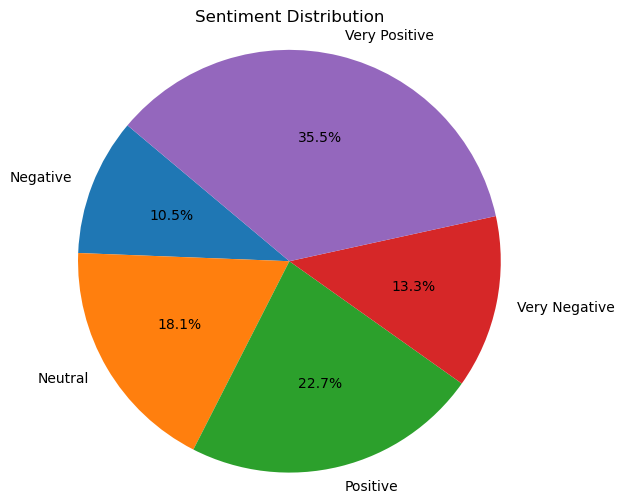

In [445]:
f = pd.read_csv('sentiment.csv')                             # Load saved sentiment labels
count = f.groupby('sentiment')['sentiment'].count()          # Count each sentiment category
sentiment_labels = count.index                                # Get unique sentiment names
sentiment_counts = count.values                               # Get counts for each sentiment

plt.figure(figsize=(6, 6))                                   # Create a square figure
plt.pie(sentiment_counts, labels=sentiment_labels, 
        autopct='%1.1f%%', startangle=140)                   # Draw pie chart with percentages
plt.title('Sentiment Distribution')                           # Add a title
plt.axis('equal')  # Ensure the pie is circular                  # Keep aspect ratio equal
plt.savefig('sentiment_distribution.png')                     # Save the figure
plt.show()                                                   # Display the plot


## Additional Text-Based Features

Based on insights from numerous studies, we also include text-derived variables—word count, average word length, and vocabulary size—for both the review title and full review text to capture writing complexity and richness.


In [12]:
def extract_text_features(text):
    words = text.split()
    word_count = len(words)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    vocab_size = len(set(words))
    
    return word_count, avg_word_length, vocab_size

df[['title_word_count', 'title_avg_word_length', 'title_vocab_size']] = df['title'].apply(lambda x: pd.Series(extract_text_features(str(x))))

df[['text_word_count', 'text_avg_word_length', 'text_vocab_size']] = df['text'].apply(lambda x: pd.Series(extract_text_features(str(x))))

## Data Export and Embedding Feature Expansion

To finalize our dataset and ensure portability across different environments, we:

- Split the 128‑dimensional embedding vector into individual features (`f0`, `f1`, …).
- Concatenate these new embedding columns with the other predictors.
- Save the full feature matrix (`X`) and target vector (`Y`) in both CSV and JSON formats to prevent oversized files or import errors on different devices.


In [22]:
X = df[[ 'average_rating', 'rating_number',  
        'rating', 'images', 'verified_purchase',
       'hour', 'year', 'rating_diff',
       'brand_rating', 'brand_rating_number', 'store_rating',
       'store_rating_number',
       'verified_purchase_review_count', 'verified_purchase_average_rating',
       'whether_discontinued_review_count',
       'whether_discontinued_average_rating', 'embedding',
       'sent_polarity', 'sent_intensity','title_word_count',
       'title_avg_word_length', 'title_vocab_size', 'text_word_count',
       'text_avg_word_length', 'text_vocab_size']]
Y = df['log_helpful_vote']

In [42]:
import ast
X["embedding"] = X["embedding"].apply(ast.literal_eval)


C:\Users\pkust\AppData\Local\Temp\ipykernel_7484\522422006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["embedding"] = X["embedding"].apply(ast.literal_eval)


In [46]:
l = len(X['embedding'][1])
f = [f'f{i}' for i in range(l)]
word_feature = pd.DataFrame(X['embedding'].to_list(),columns=f,index=X.index)
word_feature.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
0,0.075562,1.017887,-0.788219,-0.227258,-0.021471,0.691242,-0.159939,-0.503553,-0.071803,1.336526,...,-0.358659,-0.145355,0.039634,-0.031625,-0.062551,-0.013212,-0.985142,-0.330114,0.165843,-1.000361
1,0.751553,0.398718,0.536636,0.261197,-0.974006,-0.132950,0.695929,-1.108629,-0.032728,0.541800,...,0.408941,-0.588870,0.311204,-0.867065,0.430251,-0.134699,0.399696,-0.151717,-0.369950,-0.353610
2,0.272114,0.665010,-1.038528,0.153493,0.628162,-0.111177,-0.009545,0.269685,-0.524906,0.686921,...,-0.406273,0.710053,-0.814765,-0.752482,1.485290,-1.815456,-0.187296,0.467743,-0.230357,0.651337
3,0.057177,0.258172,-0.128173,0.195586,1.139891,0.196062,-1.361763,-0.529789,-0.816176,0.831935,...,-0.880785,0.364992,0.256830,-0.109251,0.737292,-0.642141,-1.284371,-1.193170,-1.063211,0.017199
4,0.083776,0.896370,0.110554,0.220788,-0.527353,1.515559,-1.005918,0.598198,-0.891192,1.367114,...,-0.798389,0.945571,-0.240634,-1.495118,-0.685916,-1.654986,-0.419318,-0.227303,-0.469150,-0.133057


In [54]:

X = pd.concat([X.drop(columns=['embedding']),word_feature],axis=1)

word_feature.to_json('word_feature.json',orient='records')
word_feature.to_csv('word_feature.csv')
X.to_json('Total_X.json',orient='records')
Y.to_json('Total_Y.json',orient='records')
X.to_csv('Total_X.csv')
Y.to_csv('Total_Y.csv')

## Exploratory Data Analysis

Here we summarize and visualize the main feature distributions to understand their ranges and relationships:

- **Summary Statistics**: Compute count, mean, std, min/max and quartiles for all predictors and save to CSV.  
- **Text Feature Histograms**: Plot the distributions of `text_word_count`, `text_avg_word_length`, and `text_vocab_size`, truncating at the 99th percentile for clarity.  
- **Pairwise Relationships**: Use a pairplot to inspect how `average_rating`, `rating_number`, and individual `rating` correlate.


In [413]:
describe = X.describe()
describe.to_csv("data_describe.csv")
describe

,average_rating,rating_number,rating,images,verified_purchase,hour,year,rating_diff,brand_rating,brand_rating_number,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
count,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,...,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000,271465.000000
mean,4.021785,39.110069,3.936979,0.106327,0.903096,2.067748,4.032115,2.553004,4.021785,71.523508,...,-0.141560,-0.085929,-0.179834,-0.024701,0.655467,-0.630549,-0.441546,0.072546,-0.628005,-0.076969
std,0.579794,82.539333,1.509737,0.308256,0.295827,1.542060,0.585555,0.886966,0.521650,147.629860,...,0.535460,0.807629,0.579093,0.600379,0.594098,0.602602,0.583563,0.620278,0.618563,0.673443
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-2.677458,-4.286323,-3.001279,-3.344228,-2.497165,-3.633039,-3.498501,-3.203277,-3.311302,-3.248649
25%,3.700000,3.000000,3.000000,0.000000,1.000000,0.869565,3.695652,1.937500,3.735443,0.000000,...,-0.470774,-0.493860,-0.520814,-0.397859,0.285055,-1.003507,-0.814561,-0.303380,-1.031180,-0.481827
50%,4.100000,10.000000,5.000000,0.000000,1.000000,1.739130,4.130435,2.250000,4.100000,14.000000,...,-0.158162,0.014623,-0.143913,-0.022176,0.630765,-0.623679,-0.475646,0.093277,-0.618839,-0.031591
75%,4.400000,35.000000,5.000000,0.000000,1.000000,3.043478,4.565217,3.062500,4.400000,70.000000,...,0.163120,0.439711,0.195215,0.335535,1.005289,-0.247973,-0.107012,0.476793,-0.231383,0.364202
max,5.000000,708.000000,5.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,1156.000000,...,2.924570,3.310239,2.812849,2.868306,3.705336,2.443398,3.104769,3.353593,3.112233,2.892220


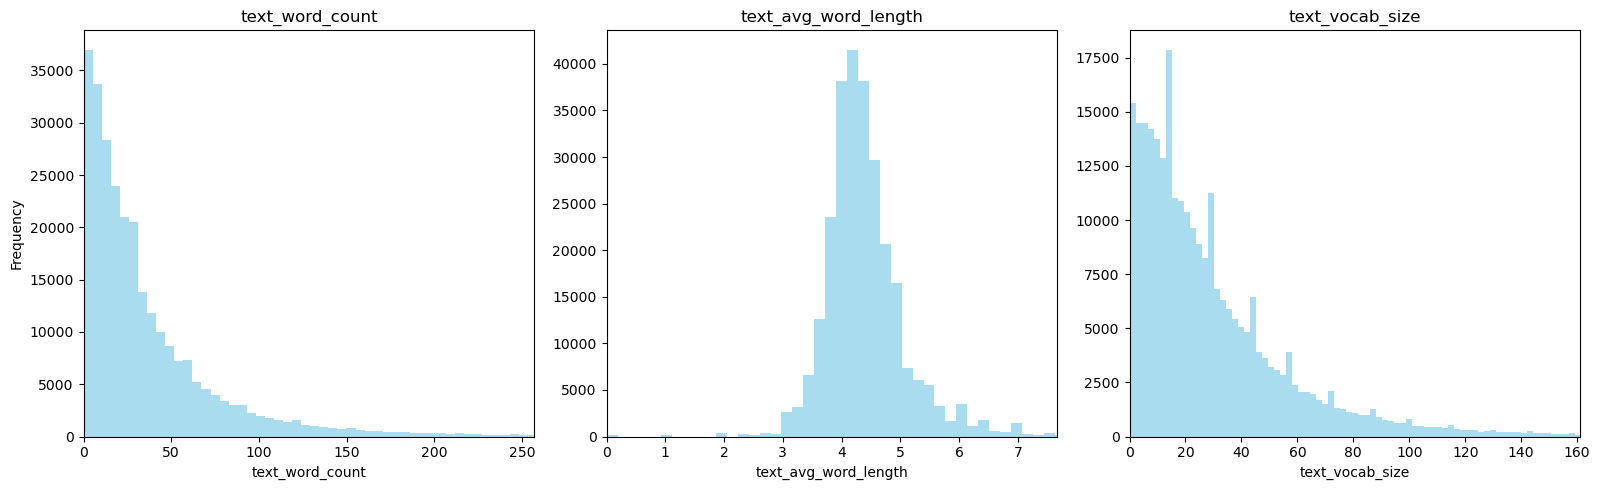

In [409]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax=plt.subplots(1,3,figsize=(16,5))
l = ['text_word_count','text_avg_word_length', 'text_vocab_size']
for i in range(3):
    ax[i].hist(train_x[l[i]], bins=500,alpha=0.7,color='skyblue')
    ax[i].set_title(l[i])
    ax[i].set_xlabel(l[i])
    if i == 0:
        ax[i].set_ylabel('Frequency')
    max_val = train_x[l[i]].quantile(0.99)
    ax[i].set_xlim(0,max_val)
plt.tight_layout()
plt.savefig('text_metadata.png', dpi=300, bbox_inches='tight')
plt.show()


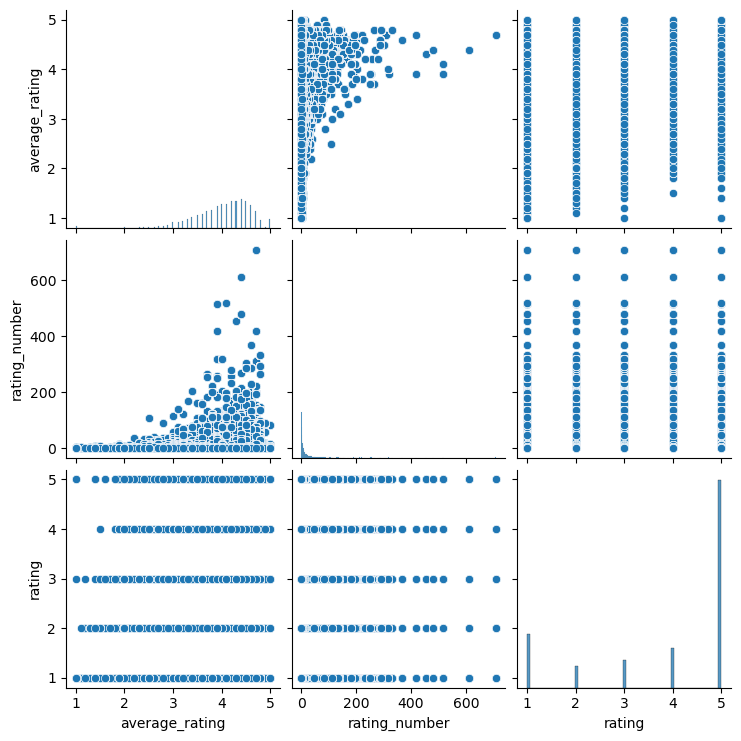

In [411]:
import seaborn as sns

cols_to_plot = ['average_rating', 'rating_number',  'rating']
sns.pairplot(train_x[cols_to_plot], diag_kind='hist')
plt.savefig('correlated_rating_data.png', dpi=300, bbox_inches='tight')
plt.show()
